In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


### Combine all files into parquet

> Add blockquote



In [ ]:
import os
import glob
import re
import pandas as pd

# Path to Balochistan's daily data folder
file_path = "/content/drive/MyDrive/FYP/cleaned_data/Daily/daily_data_balochistan/"

# Get all CSV file paths
csv_files = glob.glob(os.path.join(file_path, "*.csv"))

# Define optimized data types for memory efficiency
dtype_mapping = {
    "temperature_2m_max": "float32",
    "temperature_2m_min": "float32",
    "precipitation_sum": "float32",
    "wind_speed_10m_max": "float32",
    "wind_gusts_10m_max": "float32",
    "wind_direction_10m_dominant": "float32",
    "shortwave_radiation_sum": "float32",
    "et0_fao_evapotranspiration": "float32"
}

# List to store individual DataFrames
df_list = []

# Regex pattern to extract grid number (assumes "Grid_X" format in filename)
grid_pattern = re.compile(r"Grid_(\d+)")

# Read each CSV, extract grid ID, and append to the list
for file in csv_files:
    match = grid_pattern.search(file)
    if match:
        grid_id = int(match.group(1))  # Extract grid number
    else:
        print(f"Warning: Could not extract grid ID from {file}")
        continue  # Skip file if no grid ID found

    df = pd.read_csv(file, dtype=dtype_mapping, parse_dates=["date"])
    df["grid_id"] = grid_id  # Add grid ID column
    df_list.append(df)

# Concatenate all DataFrames
balochistan_df = pd.concat(df_list, ignore_index=True)

# Sort by date and grid ID (to keep structure consistent)
balochistan_df = balochistan_df.sort_values(by=["grid_id", "date"]).reset_index(drop=True)

# Display basic info
print(balochistan_df.info())
balochistan_df.head()

# Save merged file for future use
output_path = "/content/drive/MyDrive/FYP/processed_data/balochistan_merged.parquet"
balochistan_df.to_parquet(output_path, engine="pyarrow", index=False)
print(f"Processed data saved at: {output_path}")



,0
date,0
temperature_2m_max,0
temperature_2m_min,0
temperature_2m_mean,0
precipitation_sum,0
wind_speed_10m_max,0
wind_gusts_10m_max,0
wind_direction_10m_dominant,0
shortwave_radiation_sum,0
et0_fao_evapotranspiration,0


### Feature Engineering

In [ ]:
import pandas as pd

# Load the merged Balochistan dataset
balochistan_df = pd.read_parquet("/content/drive/MyDrive/FYP/processed_data/balochistan_merged.parquet")

# Ensure data is sorted before applying rolling calculations
balochistan_df = balochistan_df.sort_values(by=["grid_id", "date"]).reset_index(drop=True)

# Create date-based features
balochistan_df["year"] = balochistan_df["date"].dt.year
balochistan_df["month"] = balochistan_df["date"].dt.month
balochistan_df["day"] = balochistan_df["date"].dt.day
balochistan_df["day_of_year"] = balochistan_df["date"].dt.dayofyear
balochistan_df["week_of_year"] = balochistan_df["date"].dt.isocalendar().week
balochistan_df["season"] = balochistan_df["month"].map({12: "winter", 1: "winter", 2: "winter",
                                                         3: "spring", 4: "spring", 5: "spring",
                                                         6: "summer", 7: "summer", 8: "summer",
                                                         9: "fall", 10: "fall", 11: "fall"})

# Compute rolling averages
balochistan_df["temp_7d_avg"] = balochistan_df.groupby("grid_id")["temperature_2m_mean"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
balochistan_df["temp_14d_avg"] = balochistan_df.groupby("grid_id")["temperature_2m_mean"].transform(lambda x: x.rolling(window=14, min_periods=1).mean())

# Compute heatwave threshold (90th percentile of past temperatures per grid)
heatwave_thresholds = balochistan_df.groupby("grid_id")["temperature_2m_mean"].quantile(0.90).to_dict()
balochistan_df["heatwave_threshold"] = balochistan_df["grid_id"].map(heatwave_thresholds)

# Define binary heatwave labels
balochistan_df["is_heatwave_day"] = (balochistan_df["temperature_2m_mean"] > balochistan_df["heatwave_threshold"]).astype(int)

# Apply consecutive heatwave labeling (3+ consecutive hot days)
balochistan_df["heatwave_final"] = balochistan_df.groupby("grid_id")["is_heatwave_day"].transform(lambda x: x.rolling(window=3, min_periods=1).sum() >= 3).astype(int)

# Save processed file
output_path = "/content/drive/MyDrive/FYP/processed_data/balochistan_features.parquet"
balochistan_df.to_parquet(output_path, engine="pyarrow", index=False)
print(f"Feature engineered data saved at: {output_path}")

# Drop unnecessary columns
balochistan_df = balochistan_df.drop(columns=["temperature_2m_max", "temperature_2m_min", "wind_gusts_10m_max"])

# Save the updated dataset
output_path = "/content/drive/MyDrive/FYP/processed_data/balochistan_features.parquet"
balochistan_df.to_parquet(output_path, engine="pyarrow", index=False)

print(f"Updated dataset saved at: {output_path}")

# Display summary
print(balochistan_df.info())
balochistan_df.head()


Updated dataset saved at: /content/drive/MyDrive/FYP/processed_data/balochistan_features.parquet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18017816 entries, 0 to 18017815
Data columns (total 19 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   date                         datetime64[ns, UTC]
 1   temperature_2m_mean          float64            
 2   precipitation_sum            float32            
 3   wind_speed_10m_max           float32            
 4   wind_direction_10m_dominant  float32            
 5   shortwave_radiation_sum      float32            
 6   et0_fao_evapotranspiration   float32            
 7   grid_id                      int64              
 8   year                         int32              
 9   month                        int32              
 10  day                          int32              
 11  day_of_year                  int32              
 12  week_of_year               

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,grid_id,year,month,day,day_of_year,week_of_year,season,temp_7d_avg,temp_14d_avg,heatwave_threshold,is_heatwave_day,heatwave_final
0,1999-12-31 19:00:00+00:00,11.692334,0.0,16.622490,293.601318,14.43,3.357357,1,1999,12,31,365,52,winter,11.692334,11.692334,34.588433,0,0
1,2000-01-01 19:00:00+00:00,10.379834,0.0,10.966713,270.475372,14.66,2.653095,1,2000,1,1,1,52,winter,11.036084,11.036084,34.588433,0,0
2,2000-01-02 19:00:00+00:00,10.056916,0.0,8.557102,260.217438,14.63,2.443693,1,2000,1,2,2,52,winter,10.709695,10.709695,34.588433,0,0
3,2000-01-03 19:00:00+00:00,9.802751,0.0,9.178235,241.389618,14.75,2.533978,1,2000,1,3,3,1,winter,10.482959,10.482959,34.588433,0,0
4,2000-01-04 19:00:00+00:00,10.438167,0.0,9.085988,317.225952,14.23,2.665195,1,2000,1,4,4,1,winter,10.474000,10.474000,34.588433,0,0


### EDA

In [ ]:
print(balochistan_df.info())  # Column types and non-null counts
print(balochistan_df.describe())  # Summary stats
print(balochistan_df.isnull().sum())  # Missing values check


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18017816 entries, 0 to 18017815
Data columns (total 19 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   date                         datetime64[ns, UTC]
 1   temperature_2m_mean          float64            
 2   precipitation_sum            float32            
 3   wind_speed_10m_max           float32            
 4   wind_direction_10m_dominant  float32            
 5   shortwave_radiation_sum      float32            
 6   et0_fao_evapotranspiration   float32            
 7   grid_id                      int64              
 8   year                         int32              
 9   month                        int32              
 10  day                          int32              
 11  day_of_year                  int32              
 12  week_of_year                 UInt32             
 13  season                       object             
 14  temp_7d_avg     

In [ ]:
# Count heatwave vs. non-heatwave days
heatwave_counts = balochistan_df["heatwave_final"].value_counts()
print(heatwave_counts)
print()
print(balochistan_df["is_heatwave_day"].value_counts(normalize=True))


heatwave_final
0    16979106
1     1038710
Name: count, dtype: int64

is_heatwave_day
0    0.899974
1    0.100026
Name: proportion, dtype: float64


<ipython-input-16-8acc4ca9249b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_heatwaves.index, y=monthly_heatwaves.values, palette="Reds")


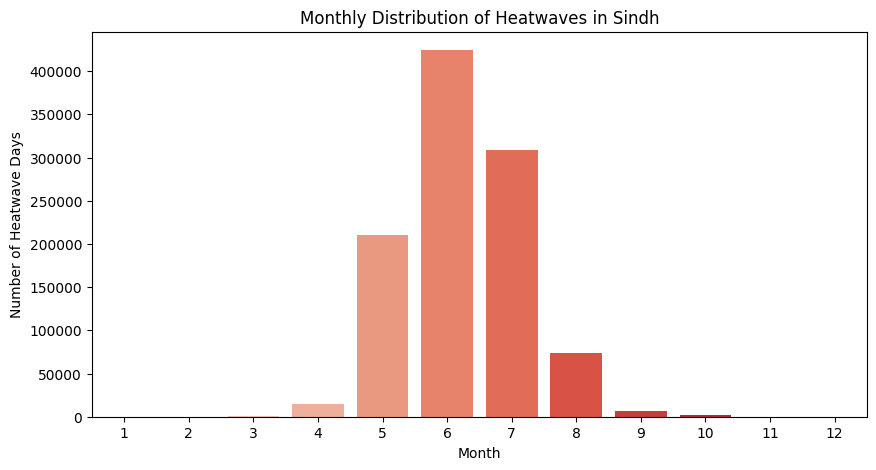

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count heatwave days per month
monthly_heatwaves = balochistan_df.groupby("month")["heatwave_final"].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_heatwaves.index, y=monthly_heatwaves.values, palette="Reds")
plt.xlabel("Month")
plt.ylabel("Number of Heatwave Days")
plt.title("Monthly Distribution of Heatwaves in Sindh")
plt.show()


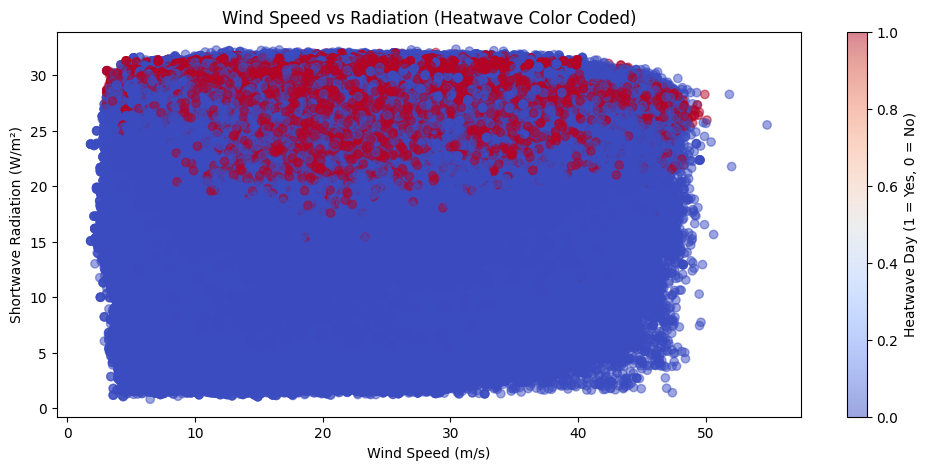

In [ ]:
plt.figure(figsize=(12, 5))
plt.scatter(balochistan_df["wind_speed_10m_max"], balochistan_df["shortwave_radiation_sum"],
            c=balochistan_df["is_heatwave_day"], cmap="coolwarm", alpha=0.5)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Shortwave Radiation (W/m²)")
plt.title("Wind Speed vs Radiation (Heatwave Color Coded)")
plt.colorbar(label="Heatwave Day (1 = Yes, 0 = No)")
plt.show()


## Model Training

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.pipeline import Pipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load Balochistan dataset
df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/balochistan_features.parquet')
df = df.dropna(subset=['et0_fao_evapotranspiration'])

def prepare_balochistan_heatwave_data(df):
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'month', 'day_of_year', 'season',
        'temp_7d_avg', 'temp_14d_avg',
        'heatwave_threshold'
    ]

    X = df[features]
    y = df['is_heatwave_day']
    return X, y, df['date']

def create_heatwave_pipeline():
    numeric_features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'day_of_year', 'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold'
    ]

    categorical_features = ['month', 'season']

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            scale_pos_weight=9,  # Adjusted for 10% heatwave days (90/10 ≈ 9)
            n_estimators=100,
            learning_rate=0.1,
            random_state=42
        ))
    ])

    return pipeline

def evaluate_heatwave_model(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    print(f"\nAverage Precision Score: {avg_prec:.4f}")

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    print(f"Optimal threshold: {optimal_threshold:.4f}")

    y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
    print("\nClassification Report with Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))

    return y_pred, y_proba, optimal_threshold

def feature_importance_analysis(pipeline, X):
    preprocessor = pipeline.named_steps['preprocessor']

    numeric_features = [
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
        'day_of_year', 'temp_7d_avg', 'temp_14d_avg', 'heatwave_threshold'
    ]

    categorical_features = ['month', 'season']
    cat_encoder = preprocessor.named_transformers_['cat']
    cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features))
    feature_names = numeric_features + cat_feature_names

    classifier = pipeline.named_steps['classifier']
    importances = classifier.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nFeature Importances:")
    print(importance_df.head(10))

    return importance_df

def main(df):
    X, y, dates = prepare_balochistan_heatwave_data(df)

    print("Class Distribution:")
    print(y.value_counts(normalize=True))

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    pipeline = create_heatwave_pipeline()
    pipeline.fit(X_train, y_train)

    y_pred, y_proba, optimal_threshold = evaluate_heatwave_model(pipeline, X_test, y_test)
    importance_df = feature_importance_analysis(pipeline, X)

    return pipeline, importance_df, optimal_threshold

# Run for Balochistan dataset
model, feature_importance, threshold = main(df)


Class Distribution:
is_heatwave_day
0    0.899974
1    0.100026
Name: proportion, dtype: float64
Training set size: 14414252 samples
Test set size: 3603564 samples

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   3243161
           1       0.93      1.00      0.96    360403

    accuracy                           0.99   3603564
   macro avg       0.96      1.00      0.98   3603564
weighted avg       0.99      0.99      0.99   3603564


Confusion Matrix:
[[3214073   29088]
 [    317  360086]]

Average Precision Score: 0.9990
Optimal threshold: 0.8625

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3243161
           1       0.98      0.98      0.98    360403

    accuracy                           1.00   3603564
   macro avg       0.99      0.99      0.99   3603564
weighted avg       1.00      1.00      1.00   360

### Save the model

In [ ]:
import joblib

# Save the trained model
joblib.dump(model, "/content/drive/MyDrive/FYP/processed_data/heatwave_balochistan_XGB.pkl")  # Update path if needed


['/content/drive/MyDrive/FYP/processed_data/heatwave_balochistan_XGB.pkl']

### Verifying prediction from historical data
May 23 and June 25, 2024

In [ ]:
#import joblib
#model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_sindh_XGB.pkl")

import pandas as pd

# Load dataset again (if needed)
#df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/sindh_heatwave.parquet')
#df = df_karachi.dropna(subset=['et0_fao_evapotranspiration'])

df_quetta = df[df["grid_id"] == 1125 ]
df=df_quetta
# Step 1: Sort by date
df = df.sort_values(by="date")

# Step 2: Compute rolling averages
#df["temp_7d_avg"] = df["temperature_2m_mean"].rolling(window=7, min_periods=1).mean()
#df["temp_14d_avg"] = df["temperature_2m_mean"].rolling(window=14, min_periods=1).mean()

# Step 3: Filter for June 18-24, 2024
df_june = df[(df["date"] >= "2024-05-20") & (df["date"] <= "2024-05-30")]

# Drop the target variable (if present)
X_new = df_june.drop(columns=["is_heatwave_day"], errors="ignore")

# Step 4: Apply the same preprocessing pipeline
X_new_transformed = model.named_steps["preprocessor"].transform(X_new)

# Step 5: Predict
predictions = model.named_steps["classifier"].predict(X_new_transformed)

# Step 6: Add predictions to DataFrame
df_june["predicted_heatwave"] = predictions

# Step 7: Show results
df_june[["date", "temperature_2m_mean", "predicted_heatwave"]]

<ipython-input-11-090e3185b91b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_june["predicted_heatwave"] = predictions


,date,temperature_2m_mean,predicted_heatwave
10163489,2024-05-20 19:00:00+00:00,26.284250,0
10163490,2024-05-21 19:00:00+00:00,27.334250,0
10163491,2024-05-22 19:00:00+00:00,27.805082,0
10163492,2024-05-23 19:00:00+00:00,29.230090,1
10163493,2024-05-24 19:00:00+00:00,29.144667,0
10163494,2024-05-25 19:00:00+00:00,29.734247,1
10163495,2024-05-26 19:00:00+00:00,28.955084,0
10163496,2024-05-27 19:00:00+00:00,27.828001,0
10163497,2024-05-28 19:00:00+00:00,26.473833,0
10163498,2024-05-29 19:00:00+00:00,26.459251,0


Verifying from cleaned data (Turbat)

In [ ]:
import pandas as pd
import joblib

# Load trained model
model = joblib.load("/content/drive/MyDrive/FYP/processed_data/heatwave_balochistan_XGB.pkl")

# Load Grid 4 data
file_path = "/content/drive/MyDrive/FYP/cleaned_data/Daily/daily_data_balochistan/Grid_213_daily_balochistan.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

# Sort by date
df = df.sort_values(by="date")

df["temp_7d_avg"] = df["temperature_2m_mean"].rolling(window=7, min_periods=1).mean()
df["temp_14d_avg"] = df["temperature_2m_mean"].rolling(window=14, min_periods=1).mean()

# Drop rows where 'et0_fao_evapotranspiration' is missing
#df = df.dropna(subset=['et0_fao_evapotranspiration'])

# Feature Engineering: Add Missing Features
df["month"] = df["date"].dt.month
df["day_of_year"] = df["date"].dt.dayofyear

# Map seasons (based on your previous work)
def get_season(month):
    if month in [12, 1, 2]: return "Winter"
    elif month in [3, 4, 5]: return "Spring"
    elif month in [6, 7, 8]: return "Summer"
    else: return "Autumn"

df["season"] = df["month"].apply(get_season)

# Load Sindh-wide dataset to get original heatwave threshold
balochistan_df = pd.read_parquet('/content/drive/MyDrive/FYP/processed_data/balochistan_features.parquet')

# Get the heatwave threshold used in training
global_heatwave_threshold = balochistan_df["heatwave_threshold"].unique()[0]

# Apply this fixed threshold to Grid 4
df["heatwave_threshold"] = global_heatwave_threshold

#df["heatwave_threshold"] = df["temperature_2m_max"].quantile(0.95)
# Filter for June 18-24, 2024
df_filtered = df[(df["date"] >= "2017-05-20") & (df["date"] <= "2017-06-15")]

# Drop target variable if present
X_new = df_filtered.drop(columns=["is_heatwave_day"], errors="ignore")

# Apply preprocessing pipeline
X_new_transformed = model.named_steps["preprocessor"].transform(X_new)

# Predict heatwave occurrence
predictions = model.named_steps["classifier"].predict(X_new_transformed)

# Store predictions in DataFrame
df_filtered["predicted_heatwave"] = predictions

# Show results
print(df_filtered[["date", "temperature_2m_mean", "predicted_heatwave"]])


                          date  temperature_2m_mean  predicted_heatwave
6333 2017-05-20 19:00:00+00:00            32.347084                   0
6334 2017-05-21 19:00:00+00:00            31.772081                   0
6335 2017-05-22 19:00:00+00:00            32.470005                   0
6336 2017-05-23 19:00:00+00:00            34.159584                   0
6337 2017-05-24 19:00:00+00:00            35.970005                   1
6338 2017-05-25 19:00:00+00:00            37.601250                   1
6339 2017-05-26 19:00:00+00:00            39.574170                   1
6340 2017-05-27 19:00:00+00:00            42.153336                   1
6341 2017-05-28 19:00:00+00:00            43.538754                   1
6342 2017-05-31 19:00:00+00:00            38.276257                   1
6343 2017-06-01 19:00:00+00:00            33.397087                   0
6344 2017-06-02 19:00:00+00:00            32.138744                   0
6345 2017-06-03 19:00:00+00:00            33.122080             

<ipython-input-11-d9c7638ed9a8>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["predicted_heatwave"] = predictions


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = model.named_steps["classifier"].feature_importances_
feature_names = model.named_steps["preprocessor"].get_feature_names_out()

# Create a DataFrame and sort by importance
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


,Feature,Importance
24,cat__season_summer,0.517008
14,cat__month_5,0.137625
6,num__day_of_year,0.112782
0,num__temperature_2m_mean,0.107747
5,num__et0_fao_evapotranspiration,0.072466
9,num__heatwave_threshold,0.046912
4,num__shortwave_radiation_sum,0.003164
18,cat__month_9,0.000915
8,num__temp_14d_avg,0.000455
16,cat__month_7,0.000405


SHAP analysis

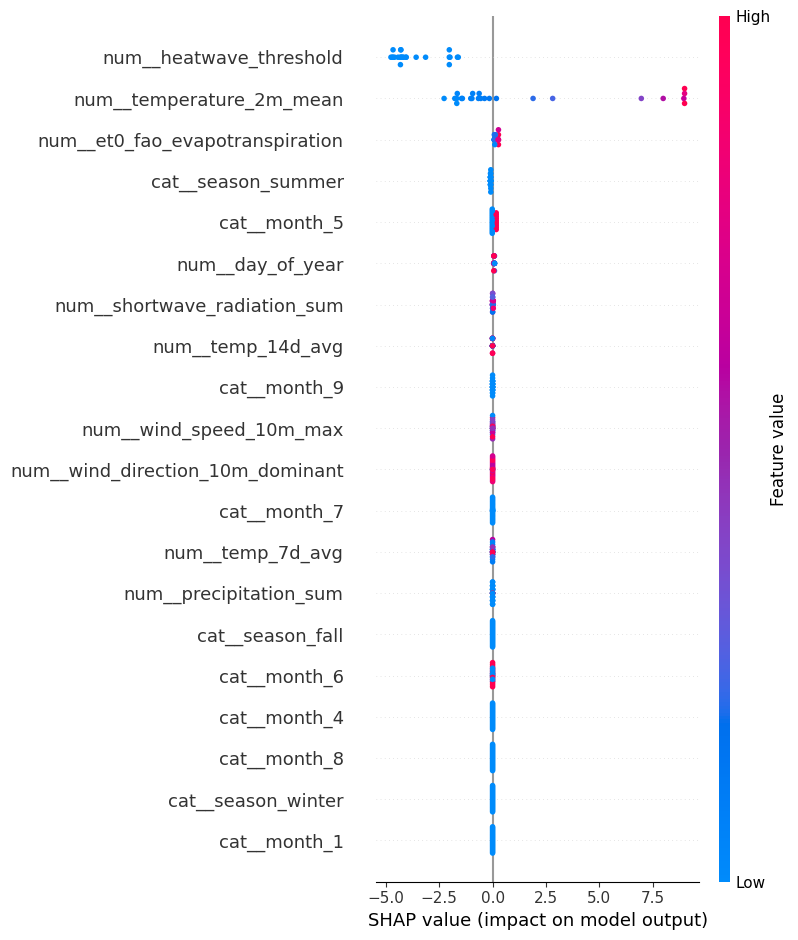

In [ ]:
import shap

explainer = shap.Explainer(model.named_steps["classifier"])
shap_values = explainer(X_new_transformed)

shap.summary_plot(shap_values, X_new_transformed, feature_names=feature_names)

shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
shap_df.head()

